In [561]:
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from astropy.io import ascii
from astropy.table import Column, join, vstack
from pipeline import *
from utils import *

%load_ext autoreload
%autoreload 2

def condition_1(cen_off, cen_off_std, z, z0=0.228, thre=1):
    return (cen_off>thre) & (cen_off>3*cen_off_std) & (abs(z-z0)<0.015) #& (z>0.22)

def condition_2(cen_off, cen_off_std, z, z0=0.228, thre=1):
    return (cen_off>thre+3*cen_off_std) & (abs(z-z0)<0.015)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [210]:
tab_A2390C = Table.read('./proc/centroid_analysis_A2390C.txt', format='ascii')
tab_A2390E = Table.read('./proc/centroid_analysis_A2390E.txt', format='ascii')
tab_A2390W = Table.read('./proc/centroid_analysis_A2390W.txt', format='ascii')
tab_A2390C

ID,ra,dec,z,X,Y,SN_Ha,SN_OIII,SN_OII,diff_angle_APER,cen_offset_APER,diff_angle_std_APER,cen_offset_std_APER,pa_APER,diff_angle_ISO-D,cen_offset_ISO-D,diff_angle_std_ISO-D,cen_offset_std_ISO-D,pa_ISO-D,diff_angle_ISO-Dm,cen_offset_ISO-Dm,diff_angle_std_ISO-Dm,cen_offset_std_ISO-Dm,pa_ISO-Dm,clus_cen_angle,dist_clus_cen
str5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
47C,328.4375,17.5799,0.2502,621.81,15.29,25.19,22.301,24.589,72.065,1.214,8.993,0.18,272.236,69.356,1.21,12.322,0.219,274.945,53.928,1.086,5.926,0.112,290.373,344.301,1342.949
148C,328.4744,17.5908,0.2394,222.78,130.34,5.018,4.622,6.012,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
207C,328.3799,17.5934,0.2553,1235.89,180.72,5.601,4.922,5.262,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
215C,328.454,17.5949,0.2548,445.2,184.47,6.109,6.407,6.495,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
276C,328.3362,17.5971,0.2542,1703.42,222.21,5.969,6.444,6.385,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
297C,328.3152,17.599,0.2189,1930.9,242.3,6.069,5.659,7.265,22.038,1.367,13.842,0.295,63.081,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
338C,328.4165,17.6032,0.255,846.83,288.28,6.435,6.304,6.287,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
389C,328.3937,17.607,0.25,1087.53,333.74,45.457,17.784,19.22,65.973,0.445,1.662,0.014,299.969,75.687,0.381,2.813,0.024,290.256,46.777,0.238,25.506,0.106,319.165,5.942,995.064
406C,328.3996,17.6077,0.2262,1025.66,340.73,5.151,4.511,5.189,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [409]:
datacube_C = Read_Datacube('./proc/A2390C/A2390C_cube.fits', 
                         name='A2390C', z0=0.228, mode="MMA",
                         table='./proc/A2390C/A2390C_MMA.dat', 
                         seg_map='./proc/A2390C/A2390C_segm_MMA.fits',
                         deep_frame='./proc/A2390C/A2390C_DF.fits',
                         mask_edge='./proc/A2390C/Raw_stack_A2390C_mask.fits')
datacube_C.get_wcs()
datacube_C.read_spec('./proc/A2390C/A2390C-spec-MMA_all.fits')

In [410]:
datacube_E = Read_Datacube('./proc/A2390E/A2390E_cube.fits',
                           name='A2390E', z0=0.228, mode="MMA",
                           table='./proc/A2390E/A2390E_MMA.dat',
                           seg_map='./proc/A2390E/A2390E_segm_MMA.fits',
                           deep_frame='./proc/A2390E/A2390E_DF.fits',
                           mask_edge='./proc/A2390E/Raw_stack_A2390E_mask.fits')
datacube_E.get_wcs()
datacube_E.read_spec('./proc/A2390E/A2390E-spec-MMA_all.fits')

In [411]:
datacube_W = Read_Datacube('./proc/A2390W/A2390W_cube.fits', 
                         name='A2390W', z0=0.228, mode="MMA",
                         table='./proc/A2390W/A2390W_MMA.dat', 
                         seg_map='./proc/A2390W/A2390W_segm_MMA.fits',
                         deep_frame='./proc/A2390W/A2390W_DF.fits',
                         mask_edge='./proc/A2390W/Raw_stack_A2390W_mask.fits')
datacube_W.get_wcs()
datacube_W.read_spec('./proc/A2390E/A2390E-spec-MMA_all.fits')

In [214]:
c_A2390C = SkyCoord(tab_A2390C['ra'], tab_A2390C['dec'], frame='icrs', unit="deg")
c_A2390E = SkyCoord(tab_A2390E['ra'], tab_A2390E['dec'], frame='icrs', unit="deg")
c_A2390W = SkyCoord(tab_A2390W['ra'], tab_A2390W['dec'], frame='icrs', unit="deg")

idx, d2d, d3d = c_A2390E.match_to_catalog_sky(c_A2390C)
match = d2d < 3*u.arcsec
tab_EC = tab_A2390E[match]
tab_CE = tab_A2390C[idx[match]]

idx, d2d, d3d = c_A2390W.match_to_catalog_sky(c_A2390C)
match = d2d < 3*u.arcsec
tab_WC = tab_A2390W[match]
tab_CW = tab_A2390C[idx[match]]

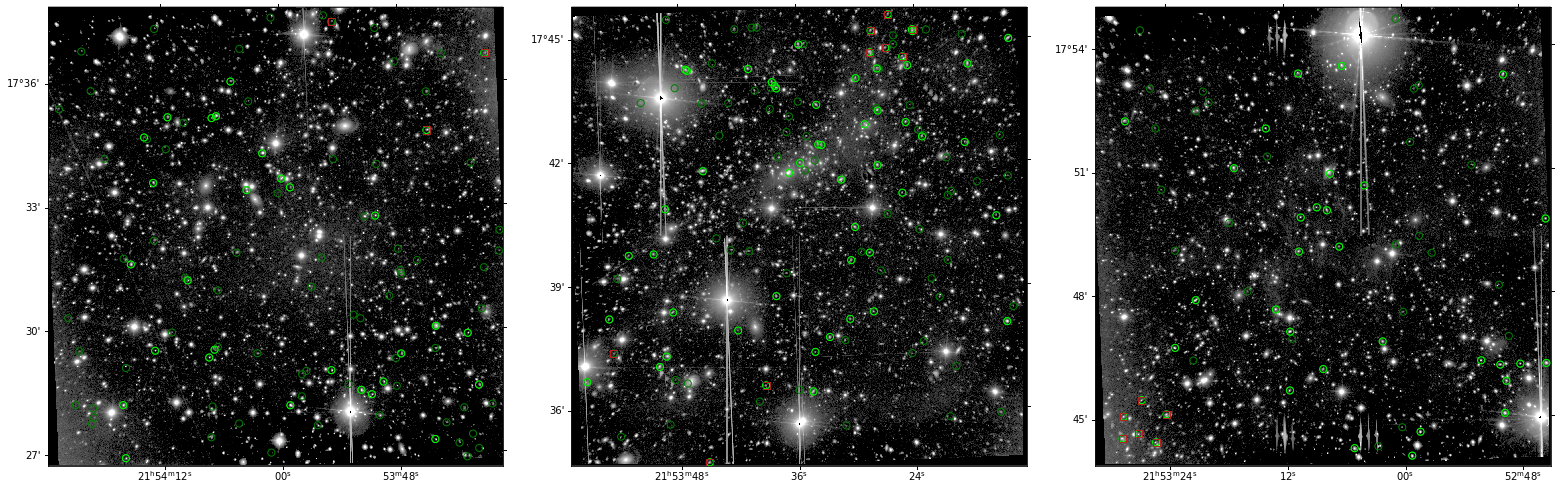

In [231]:
fig = plt.figure(figsize=(24,8))
for i, (datacube, tab) in enumerate(zip([datacube_E,datacube_C,datacube_W],[tab_A2390E,tab_A2390C,tab_A2390W])):
    ax = plt.subplot(1, 3, i+1, projection=datacube.wcs)
    plt.scatter(tab['X'], tab['Y'], s=50, facecolor="none", edgecolor="g")

    tab_iso = tab[tab['cen_offset_ISO-D']>0]
    plt.scatter(tab_iso['X'], tab_iso['Y'], s=50, facecolor="none", edgecolor="lime")
    
    if i==0:
        plt.scatter(tab_EC['X'], tab_EC['Y'], s=50, marker='s', facecolor="none", edgecolor="firebrick")
    if i==1:
        plt.scatter(tab_CE['X'], tab_CE['Y'], s=50, marker='s', facecolor="none", edgecolor="firebrick")
        plt.scatter(tab_CW['X'], tab_CW['Y'], s=50, marker='s', facecolor="none", edgecolor="firebrick")
        
    if i==2:
        plt.scatter(tab_WC['X'], tab_WC['Y'], s=50, marker='s', facecolor="none", edgecolor="firebrick")
    
    plt.imshow(datacube.deep_frame, norm=norm1, cmap='gray', vmin=np.median(datacube.deep_frame), vmax=1e3)
plt.subplots_adjust(left=0.08, right=0.95, bottom=0.1, top=0.9, wspace=0.15)
plt.savefig('./pic/ELG_field.pdf')

In [529]:
tab_E, tab_C, tab_W = tab_A2390E.copy(), tab_A2390C.copy(), tab_A2390W.copy()
tab_A2390 = vstack([tab_C, tab_E , tab_W], join_type='exact')

# Remove repeated source with lower SNR
good_E = tab_EC['SN_Ha']>tab_CE['SN_Ha']
id_rm_EC = tab_EC['ID'][~good_E].data
id_rm_CE = tab_CE['ID'][good_E].data

good_W = tab_WC['SN_Ha']>tab_CW['SN_Ha']
id_rm_WC = tab_WC['ID'][~good_W].data
id_rm_CW = tab_CW['ID'][good_W].data

for id_rm in np.concatenate([id_rm_EC, id_rm_WC, id_rm_CW, id_rm_CE]):
    tab_A2390.remove_row(np.where(tab_A2390['ID']==id_rm)[0][0])

In [530]:
tab = tab_A2390.copy()
id_non_clus = ['67C','226C','622C','1316C','1356C', '1442C', '1698C',
               '1745C', '1819C', '1837C', '2811C','3942W','2561W','3942W',
               '507E', '1102E', '1876E', '2113E', '3031E', '3813E', '3539E']

irow_non_clus = np.array([],dtype=int)
for id_non in id_non_clus:
    irow_non_clus = np.append(irow_non_clus, np.argwhere(tab['ID']==id_non))
tab.remove_rows(irow_non_clus)
tab.remove_row(np.argmin((tab['X']-980)**2 + (tab['Y']-1315)**2))

tab

ID,ra,dec,z,X,Y,SN_Ha,SN_OIII,SN_OII,diff_angle_APER,cen_offset_APER,diff_angle_std_APER,cen_offset_std_APER,pa_APER,diff_angle_ISO-D,cen_offset_ISO-D,diff_angle_std_ISO-D,cen_offset_std_ISO-D,pa_ISO-D,diff_angle_ISO-Dm,cen_offset_ISO-Dm,diff_angle_std_ISO-Dm,cen_offset_std_ISO-Dm,pa_ISO-Dm,clus_cen_angle,dist_clus_cen
str5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
148C,328.4744,17.5908,0.2394,222.78,130.34,5.018,4.622,6.012,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
207C,328.3799,17.5934,0.2553,1235.89,180.72,5.601,4.922,5.262,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
215C,328.454,17.5949,0.2548,445.2,184.47,6.109,6.407,6.495,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
276C,328.3362,17.5971,0.2542,1703.42,222.21,5.969,6.444,6.385,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
297C,328.3152,17.599,0.2189,1930.9,242.3,6.069,5.659,7.265,22.038,1.367,13.842,0.295,63.081,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
338C,328.4165,17.6032,0.255,846.83,288.28,6.435,6.304,6.287,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
389C,328.3937,17.607,0.25,1087.53,333.74,45.457,17.784,19.22,65.973,0.445,1.662,0.014,299.969,75.687,0.381,2.813,0.024,290.256,46.777,0.238,25.506,0.106,319.165,5.942,995.064
406C,328.3996,17.6077,0.2262,1025.66,340.73,5.151,4.511,5.189,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
428C,328.4138,17.6096,0.2309,874.38,361.16,26.037,18.095,23.159,121.096,1.77,4.179,0.134,232.301,112.589,2.119,2.62,0.097,240.809,75.499,1.21,7.635,0.161,277.898,353.397,966.34


(array([10., 32., 31., 18., 12.,  3.,  3.,  1.,  0.,  2.,  0.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5]),
 <a list of 11 Patch objects>)

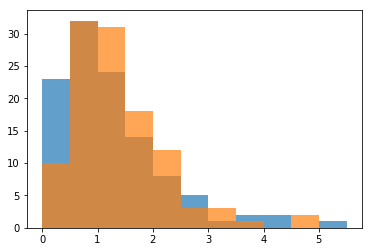

In [511]:
plt.hist(tab_A2390['cen_offset_ISO-D'], bins=np.arange(0,6,0.5),alpha=0.7)
plt.hist(tab_A2390['cen_offset_ISO-Dm'], bins=np.arange(0,6,0.5),alpha=0.7)

### SImple redshift cut : $\Delta z$ <0.02

(array([18.,  9.,  5.,  5., 13., 10.]),
 array([  0.,  30.,  60.,  90., 120., 150., 180.]),
 <a list of 1 Patch objects>)

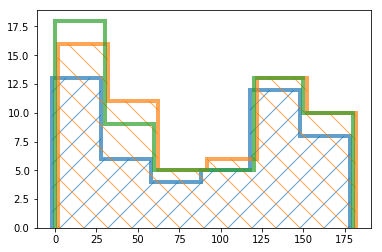

In [539]:
cond_iso = condition_1(tab['cen_offset_ISO-D'], tab['cen_offset_std_ISO-D'], tab['z'], thre=1) # 1 pix
cond_mor = condition_1(tab['cen_offset_ISO-Dm'], tab['cen_offset_std_ISO-Dm'], tab['z'], thre=1) # 1 pix
d_angle_iso = tab['diff_angle_ISO-D'][cond_iso]
d_angle_mor = tab['diff_angle_ISO-Dm'][cond_mor]
plt.hist(d_angle_iso-2, histtype="step", bins=np.linspace(0,180,7)-2, hatch="/", lw=4, alpha=0.7)
plt.hist(d_angle_mor+2, histtype="step", bins=np.linspace(0,180,7)+2, hatch="\\", lw=4, alpha=0.7)

cond_iso = condition_1(tab['cen_offset_ISO-D'], tab['cen_offset_std_ISO-D'], tab['z'], thre=0.855) # 1kpc
d_angle_iso = tab['diff_angle_ISO-D'][cond_iso]
plt.hist(d_angle_iso, histtype="step", bins=np.linspace(0,180,7), hatch="", lw=4, alpha=0.7)


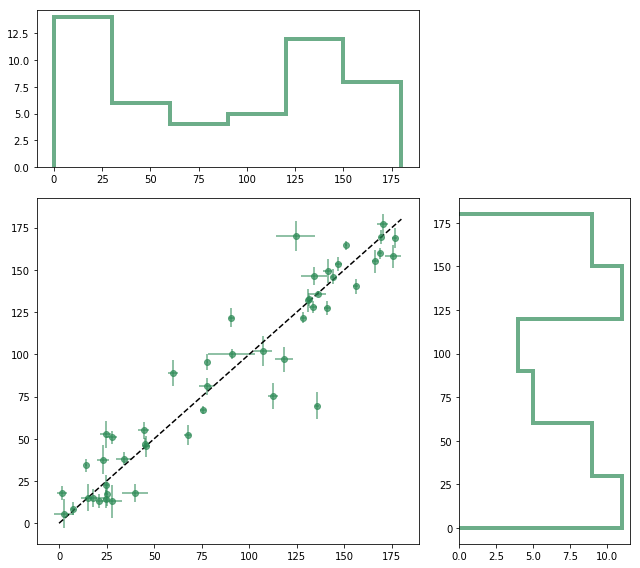

In [533]:
fig = plt.figure(figsize=(9,8))
ax1 = plt.subplot2grid((3, 3), (1, 0), rowspan=2, colspan=2)
ax1.errorbar(tab['diff_angle_ISO-D'][cond_iso&cond_mor], tab['diff_angle_ISO-Dm'][cond_iso&cond_mor],
             xerr=tab['diff_angle_std_ISO-D'][cond_iso&cond_mor],
             yerr=tab['diff_angle_std_ISO-Dm'][cond_iso&cond_mor], fmt="o", color="seagreen", alpha=0.7)
xx = np.linspace(0,180,10)
plt.plot(xx,xx,"k--")

ax2 = plt.subplot2grid((3, 3), (0, 0), colspan=2)
ax2.hist(tab['diff_angle_ISO-D'][cond_iso&cond_mor], histtype="step", bins=np.linspace(0,180,7),
         color="seagreen", lw=4, alpha=0.7)
ax3 = plt.subplot2grid((3, 3), (1, 2), rowspan=2)
ax3.hist(tab['diff_angle_ISO-Dm'][cond_iso&cond_mor], histtype="step", bins=np.linspace(0,180,7),
         color="seagreen", orientation="horizontal", lw=4, alpha=0.7, )
plt.tight_layout()

### Cut from Phase Space Diagram

In [521]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import astropy.constants as c

def V_esc(R, R_vir=1.55*u.Mpc, M_vir=1e14*c.M_sun, C=6):
    s = R/R_vir
    v_esc = np.sqrt(2*c.G*M_vir*K(s,C)/R_vir).to(u.km/u.s)
    return v_esc
    
def K(s,C=6):
    return g_c(C)*np.log(1+C*s)/s

def g_c(C):
    return 1./(np.log(1+C)-C/(1+C))

def Sigma_vir(R_vir, M_vir):
    return np.sqrt(c.G*M_vir/R_vir).to(u.km/u.s)

from astropy.cosmology import FlatLambdaCDM
h = 0.7
cosmo = FlatLambdaCDM(H0=100*h, Om0=0.3)
distance_cluster = cosmo.angular_diameter_distance(z=0.228)
print(distance_cluster)

len_1arc = distance_cluster*u.arcsec.to(u.rad)
len_pix = len_1arc * 0.322  #pixel length in Mpc
print(len_pix)
print("1kpc = %.3f pix"%(1/len_pix.to(u.kpc)).value)

v_vir = 1100 * u.km/u.s #velocity_dispersion
R_vir = 1.51/h * u.Mpc
print(R_vir, v_vir)

l_R200 = (len_pix/R_vir).value # pixel length in R200 1 pix = l R_vir

752.8932528699639 Mpc
0.0011753416970886723 Mpc
1kpc = 0.851 pix
2.1571428571428575 Mpc 1100.0 km / s


In [522]:
df = pd.read_csv("/home/qliu/Downloads/Rhee2017.csv",header=None)
r_Rhee, v_Rhee = df.iloc[:,0], df.iloc[:,1]

rr = np.linspace(0.001,10,100) *u.Mpc
# R_3d_vir = 1*u.Mpc
sigma_v = Sigma_vir(R_vir=R_vir, M_vir=2e15*c.M_sun)
vv = V_esc(rr, R_vir=R_vir, M_vir=2e15*c.M_sun, C=6)

In [544]:
def draw_phase_diagram(table, cond, centroid_type='ISO-D', r1=1., v1=1., r2=2., v2 = 3., z0=0.228, ax=None):
    r_norm = table['dist_clus_cen'] * l_R200  # normed distance in R200
    v_norm = abs(table['z']-z0) * 3e5*u.km/u.s / v_vir # normed vel in v_vir (sigma_vir)
    
    d_cen_v = table['cen_offset'+'_'+centroid_type]
    d_cen_std_v = table['cen_offset'+'_'+centroid_type]
    d_angle_v = table['diff_angle'+'_'+centroid_type]
    
    v_esc = lambda r: V_esc(r, R_vir=R_vir, M_vir=2e15*c.M_sun, C=6)
    vv = v_esc(r_norm*R_vir)
    
#     in_cluster = (((r_norm/r2)**2 + (v_norm/v2)**2) < 1.)  # circle
#     in_cluster = ((v_norm/v1) < 1.5*(r_norm/r1)**(-0.5))   # inv-square
    in_cluster = v_norm < (vv/sigma_v)   # escape vel

    cond1, cond2 = cond&(d_angle_v<=90)& in_cluster, cond&(d_angle_v>90)& in_cluster
    
    if ax is None:
        plt.figure(figsize=(11,9))
        ax = plt.subplot(111)
        
    plt.scatter(r_norm[~(cond1|cond2)& in_cluster], v_norm[~(cond1|cond2)& in_cluster], s=150, color="gray",
                edgecolor="none",alpha=0.8,zorder=3, label=None)
    plt.scatter(r_norm[cond1], v_norm[cond1], s=250, color="steelblue",
                edgecolor="none",alpha=0.8,zorder=3,label="$\Delta\,d>1$ pix , $\\theta<90^\circ$")
    plt.scatter(r_norm[cond2], v_norm[cond2], s=250, color="firebrick",
                edgecolor="none",alpha=0.8,zorder=3,label="$\Delta\,d>1$ pix , $\\theta>90^\circ$")
    
    virial = ((r_norm/r1)**2 + (v_norm/v1)**2) <= 1.
    non_virial = (~virial) & in_cluster
#     inner = ((r_norm/r1)**2 <= 1.) & in_cluster
#     outer = ((r_norm/r1)**2 > 1.) &  in_cluster   
    
    condA = non_virial & (r_norm<=1) 
    condB = virial  
    condC = non_virial & (r_norm>1)   

    condA1, condB1, condC1 = condA&cond1, condB&cond1, condC&cond1  
    condA2, condB2, condC2 = condA&cond2, condB&cond2, condC&cond2 
                  
    plt.text(0.05, 0.84,r"$\bf A$",color="k",va="center",fontsize=25,transform=ax.transAxes)
    plt.text(0.05, 0.22,r"$\bf B$",color="k",va="center",fontsize=25,transform=ax.transAxes)
    plt.text(0.85, 0.1,r"$\bf C$",color="k",va="center",fontsize=25,transform=ax.transAxes)
   
    ft = 22
    plt.text(0.76, 0.94,"A :",color="k",va="center",fontsize=ft,transform=ax.transAxes)
    plt.text(0.76, 0.86,"B :",color="k",va="center",fontsize=ft,transform=ax.transAxes)
    plt.text(0.76, 0.78,"C :",color="k",va="center",fontsize=ft,transform=ax.transAxes)
    plt.text(0.84, 0.94,"%d"%(np.sum(condA1)),color="steelblue",va="center",fontsize=ft,transform=ax.transAxes)
    plt.text(0.84, 0.86,"%d"%(np.sum(condB1)),color="steelblue",va="center",fontsize=ft,transform=ax.transAxes)
    plt.text(0.84, 0.78,"%d"%(np.sum(condC1)),color="steelblue",va="center",fontsize=ft,transform=ax.transAxes)
    plt.text(0.9, 0.94,"%d"%(np.sum(condA2)),color="firebrick",va="center",fontsize=ft,transform=ax.transAxes)
    plt.text(0.9, 0.86,"%d"%(np.sum(condB2)),color="firebrick",va="center",fontsize=ft,transform=ax.transAxes)
    plt.text(0.9, 0.78,"%d"%(np.sum(condC2)),color="firebrick",va="center",fontsize=ft,transform=ax.transAxes)

    from matplotlib.patches import Ellipse
    ellipse1 = Ellipse(xy=(0,0), width=2*r1, height=2*v1, 
                      edgecolor='orange', fc='orange', lw=5, alpha=0.4,zorder=2)
    ax.add_patch(ellipse1)
#     ellipse2 = Ellipse(xy=(0,0), width=2*r2, height=2*v2, 
#                       edgecolor='gray', fc='gray', lw=3, alpha=0.2,zorder=1)
#     ax.add_patch(ellipse2)
    
    xx = np.linspace(0.01,2.2*R_vir.value) * u.Mpc
    plt.fill_between(xx/R_vir, y1=v_esc(xx)/sigma_v,y2=0,color='seagreen',alpha=0.2,zorder=1)
    
    plt.vlines(1, ymin=0.01, ymax=v_esc(R_vir)/sigma_v,color="k",linestyle=":", alpha=0.7, lw=4)

    plt.xlim(-0.005, r2+0.05), plt.ylim(-0.005, v2+0.1)
    plt.xticks(fontsize=14), plt.yticks(fontsize=14)
    plt.xlabel("r / R$_{200}$",fontsize=18)
    plt.ylabel("|v$_{los}$ - v$_0$| / $\sigma_{vir}$",fontsize=18)
    plt.legend(loc=9,fontsize=14)
    plt.tight_layout()
    return in_cluster

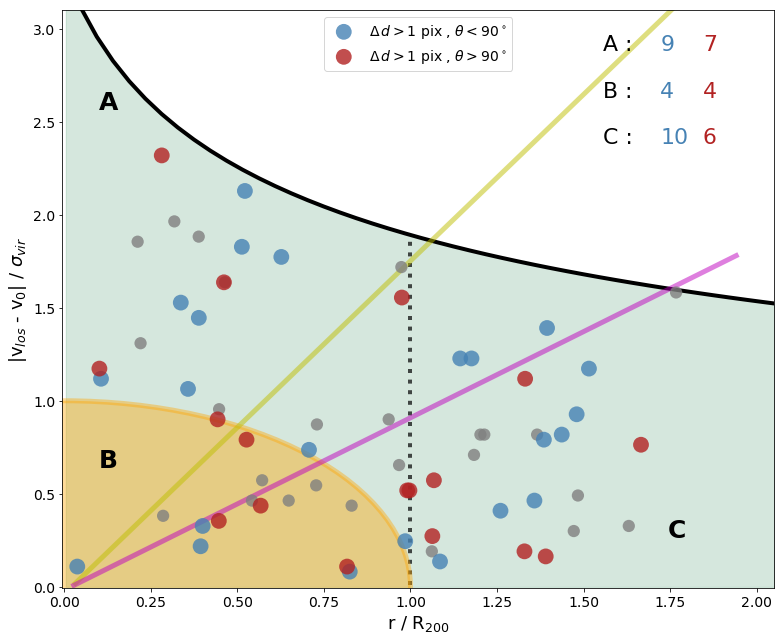

In [552]:
cond_iso = condition_1(tab['cen_offset_ISO-D'], tab['cen_offset_std_ISO-D'], tab['z'], thre=0.855) # 1kpc

in_cluster = draw_phase_diagram(tab, cond_iso, centroid_type='ISO-D')
# plt.plot(r_Rhee, v_Rhee, color="m",ls="--",label="Rhee2017")
plt.plot(rr/R_vir, vv/sigma_v, color="k",lw=4,ls="-")

df = pd.read_csv("/home/qliu/Downloads/Jaffe2018a.csv",header=None)  #Jaffe2018
r_Jafa, v_Jafa = df.iloc[:,0], df.iloc[:,1]
plt.plot(np.unique(r_Jafa), np.poly1d(np.polyfit(r_Jafa, v_Jafa, 1))(np.unique(r_Jafa)),
         color="y", lw=5,ls="-",alpha=0.5,label="High M Galaxy")

df = pd.read_csv("/home/qliu/Downloads/Jaffe2018b.csv",header=None)  #Jaffe2018
r_Jafa, v_Jafa = df.iloc[:,0], df.iloc[:,1]
plt.plot(np.unique(r_Jafa), np.poly1d(np.polyfit(r_Jafa, v_Jafa, 1))(np.unique(r_Jafa)),
         color="m", lw=5,ls="-",alpha=0.5,label="Low M Galaxy")


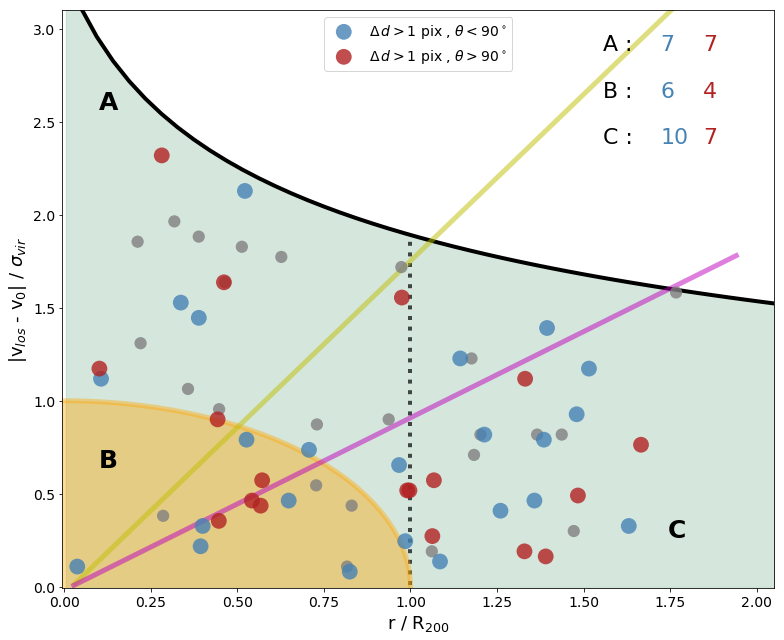

In [525]:
cond_mor = condition_1(tab['cen_offset_ISO-Dm'], tab['cen_offset_std_ISO-Dm'], tab['z'], thre=1) # 1kpc

(virial, non_virial, inner, outer) = draw_phase_diagram(tab, cond_mor, centroid_type='ISO-Dm')
# plt.plot(r_Rhee, v_Rhee, color="m",ls="--",label="Rhee2017")
plt.plot(rr/R_vir, vv/sigma_v, color="k",lw=4,ls="-")

df = pd.read_csv("/home/qliu/Downloads/Jaffe2018a.csv",header=None)  #Jaffe2018
r_Jafa, v_Jafa = df.iloc[:,0], df.iloc[:,1]
plt.plot(np.unique(r_Jafa), np.poly1d(np.polyfit(r_Jafa, v_Jafa, 1))(np.unique(r_Jafa)),
         color="y", lw=5,ls="-",alpha=0.5,label="High M Galaxy")

df = pd.read_csv("/home/qliu/Downloads/Jaffe2018b.csv",header=None)  #Jaffe2018
r_Jafa, v_Jafa = df.iloc[:,0], df.iloc[:,1]
plt.plot(np.unique(r_Jafa), np.poly1d(np.polyfit(r_Jafa, v_Jafa, 1))(np.unique(r_Jafa)),
         color="m", lw=5,ls="-",alpha=0.5,label="Low M Galaxy")


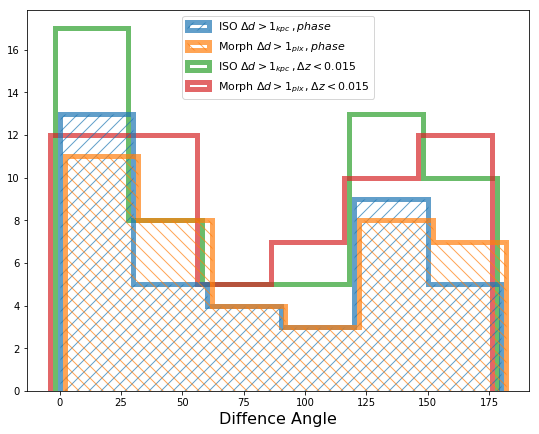

In [642]:
plt.figure(figsize=(9,7))
cond_iso = condition_1(tab['cen_offset_ISO-D'], tab['cen_offset_std_ISO-D'], tab['z'], thre=0.855) # 1 kpc
cond_mor = condition_1(tab['cen_offset_ISO-Dm'], tab['cen_offset_std_ISO-Dm'], tab['z'], thre=1) # 1 pix

d_angle_iso = tab['diff_angle_ISO-D'][cond_iso & in_cluster]
d_angle_mor = tab['diff_angle_ISO-Dm'][cond_mor & in_cluster]
plt.hist(d_angle_iso-2, histtype="step", bins=np.linspace(0,180,7), hatch="//", lw=5, alpha=0.7,
        label='ISO $\Delta d>1_{kpc}\,,phase$',zorder=2)
plt.hist(d_angle_mor+2, histtype="step", bins=np.linspace(0,180,7)+2, hatch="\\\\", lw=5, alpha=0.7,
        label='Morph $\Delta d>1_{pix}\,,phase$',zorder=2)

d_angle_iso_2 = tab['diff_angle_ISO-D'][cond_iso]
d_angle_mor_2 = tab['diff_angle_ISO-Dm'][cond_mor]
plt.hist(d_angle_iso_2-2, histtype="step", bins=np.linspace(0,180,7)-2, hatch="", lw=5, alpha=0.7,
        label='ISO $\Delta d>1_{kpc}\,,\Delta z<0.015$',zorder=1)
plt.hist(d_angle_mor_2+2, histtype="step", bins=np.linspace(0,180,7)-4, hatch="", lw=5, alpha=0.7,
         label='Morph $\Delta d>1_{pix}\,,\Delta z<0.015$',zorder=1)
plt.xlabel('Diffence Angle', fontsize=16)

# cond_iso = condition_1(tab['cen_offset_ISO-D'], tab['cen_offset_std_ISO-D'], tab['z'], thre=1) # 1 pix
# d_angle_iso = tab['diff_angle_ISO-D'][cond_mor & in_cluster]
# plt.hist(d_angle_iso, histtype="step", bins=np.linspace(0,180,7), hatch="", lw=4, alpha=0.7)


# cond_iso = condition_1(tab['cen_offset_ISO-D'], tab['cen_offset_std_ISO-D'], tab['z'], thre=1) # 1 pix
# d_angle_iso = tab['diff_angle_ISO-D'][cond_iso]
# plt.hist(d_angle_iso, histtype="step", bins=np.linspace(0,180,7), hatch="", lw=4, alpha=0.7)
plt.legend(loc=9,fontsize=11)

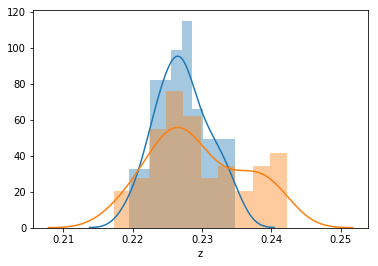

In [638]:
sns.distplot(tab['z'][cond_iso&in_cluster], bins=10)
sns.distplot(tab['z'][cond_iso], bins=10)

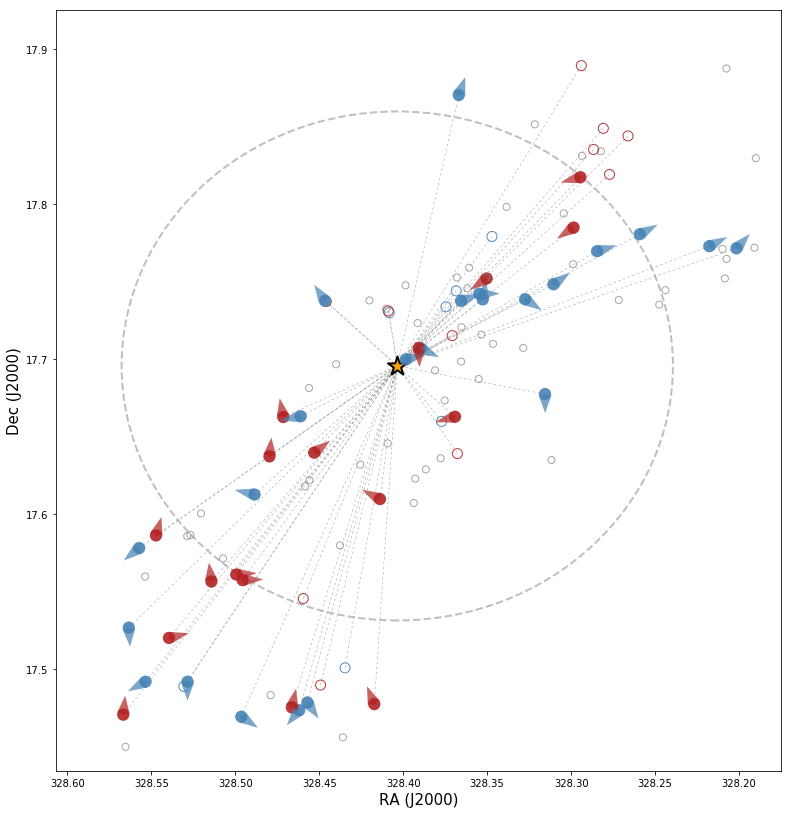

In [658]:
fig, ax = plt.subplots(figsize=(13,14))
ax.set_xlim(tab['ra'].max() + 0.015, tab['ra'].min() - 0.015)
ax.set_ylim(tab['dec'].min() - 0.015, tab['dec'].max() + 0.015)
plt.xlabel("RA (J2000)", fontsize=15)
plt.ylabel("Dec (J2000)", fontsize=15)

coord_BCG = (328.40351201,17.69544013)

plt.scatter(coord_BCG[0], coord_BCG[1], s=400, marker='*', edgecolor="k", color="orange", lw=2, alpha=1,zorder=2)

circle = plt.Circle(coord_BCG, R_vir/len_pix*0.322/3600, color='gray', ls="--", lw=2., alpha=0.5, fill=False)
ax.add_artist(circle)
for k, (ID, x, y, pa, theta) in enumerate(zip(tab['ID'], tab['ra'], tab['dec'],
                                               tab['pa_ISO-D'], tab['diff_angle_ISO-D'])):
    color = "steelblue" if theta<90 else "firebrick"
    if (cond_iso& in_cluster)[k]:
        plt.scatter(x, y, s=150, color=color, edgecolors="none", alpha=0.9,zorder=2)
        plt.plot((x,coord_BCG[0]), (y,coord_BCG[1]), color="gray", ls="--", dashes=(5,5),  lw=.5, alpha=0.8, zorder=1)
        plt.arrow(x, y, -np.sin(pa*np.pi/180)*0.001, -np.cos(pa*np.pi/180)*0.001, 
                  color=color, width=0.0025, lw=0.01, alpha=0.7, zorder=2)
#         plt.text(x+(np.random.rand()*1-2)*0.002,y+(np.random.rand()*1-2)*0.002,'#'+ID,color='k',fontsize=8)
    elif (cond_iso & (~in_cluster))[k]:
        plt.scatter(x, y, s=100, facecolors="none", edgecolors=color, alpha=0.9,zorder=2)
        plt.plot((x,coord_BCG[0]), (y,coord_BCG[1]), color="gray", ls="--", dashes=(5,5),  lw=.5, alpha=0.8, zorder=1)
        plt.arrow(x, y, -np.sin(pa*np.pi/180)*0.001, -np.cos(pa*np.pi/180)*0.001, 
                  ec=color, fc="none", width=0.002, lw=0.01, alpha=0.7, zorder=2)
#         plt.text(x+(np.random.rand()*1-2)*0.002,y+(np.random.rand()*1-2)*0.002,'#'+ID,color='k',fontsize=7)
    elif theta>0:
        plt.scatter(x, y, s=50, facecolor='none', color="gray", alpha=0.7, zorder=2)


<IPython.core.display.Javascript object>


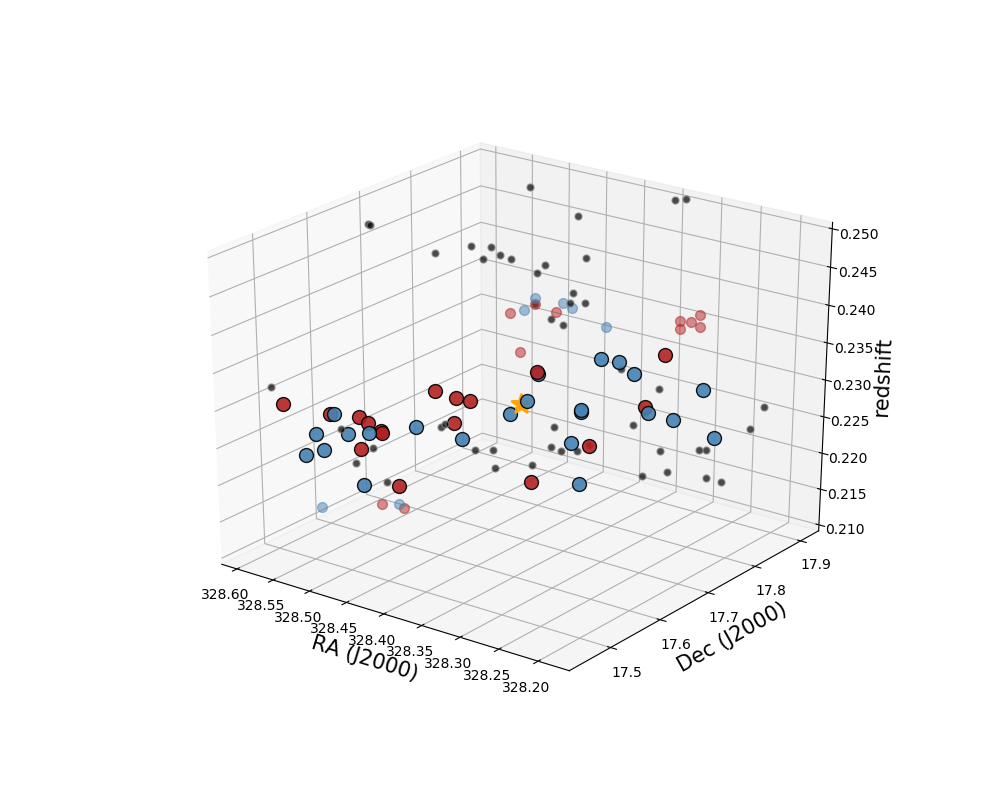

In [708]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D 

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

ax.set_xlim(tab['ra'].max() + 0.02, tab['ra'].min() - 0.02)
ax.set_ylim(tab['dec'].min() - 0.02, tab['dec'].max() + 0.02)
ax.set_zlim(0.21,0.25)
ax.set_xlabel("RA (J2000)", fontsize=15)
ax.set_ylabel("Dec (J2000)", fontsize=15)
ax.set_zlabel("redshift", fontsize=15)

coord_BCG = (328.40351201,17.69544013)

ax.scatter(coord_BCG[0], coord_BCG[1], 0.228, s=200, marker='*', color="orange", lw=2, alpha=1,zorder=2)

for k, (ID, x, y, z, pa, theta) in enumerate(zip(tab['ID'], tab['ra'], tab['dec'], tab['z'],
                                               tab['pa_ISO-D'], tab['diff_angle_ISO-D'])):
    color = "steelblue" if theta<90 else "firebrick"
    if (cond_iso& in_cluster)[k]:
        ax.scatter(x, y, z, s=100, color=color, edgecolors="none", alpha=0.9,zorder=2)
#         ax.plot((coord_BCG[0],x), (coord_BCG[1],y), (0.228,z), color="gray", ls="--", dashes=(5,5), lw=.5, alpha=0.8, zorder=1)
#         ax.arrow(x, y, z, -np.sin(pa*np.pi/180)*0.001, -np.cos(pa*np.pi/180)*0.001, 0,
#                   color=color, width=0.0025, lw=0.01, alpha=0.7, zorder=2)
        ax.quiver(x, y, z, -np.sin(pa*np.pi/180)*0.001, -np.cos(pa*np.pi/180)*0.001, 0,
                  color=color, length=0.1, alpha=0.7, zorder=2)
#         plt.text(x+(np.random.rand()*1-2)*0.002,y+(np.random.rand()*1-2)*0.002,'#'+ID,color='k',fontsize=8)
    elif (cond_iso & (~in_cluster))[k]:
        ax.scatter(x, y, z, s=50,  color=color, alpha=0.5,zorder=2)
#         ax.arrow(x, y, z, -np.sin(pa*np.pi/180)*0.001, -np.cos(pa*np.pi/180)*0.001, 0,
#                   ec=color, fc="none", width=0.002, lw=0.01, alpha=0.7, zorder=2)
#         plt.text(x+(np.random.rand()*1-2)*0.002,y+(np.random.rand()*1-2)*0.002,'#'+ID,color='k',fontsize=7)
    elif theta>0:
        ax.scatter(x, y, z, s=25, facecolor='none', color="gray", alpha=0.7, zorder=2)


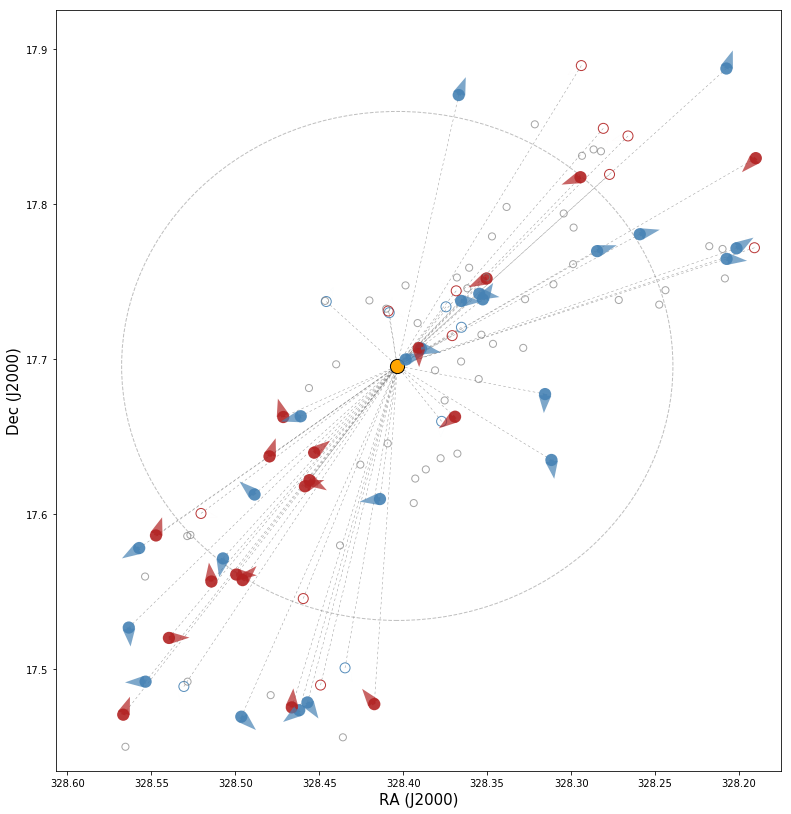

In [644]:
fig, ax = plt.subplots(figsize=(13,14))
ax.set_xlim(tab['ra'].max() + 0.015, tab['ra'].min() - 0.015)
ax.set_ylim(tab['dec'].min() - 0.015, tab['dec'].max() + 0.015)
plt.xlabel("RA (J2000)", fontsize=15)
plt.ylabel("Dec (J2000)", fontsize=15)

coord_BCG = (328.40351201,17.69544013)

plt.scatter(coord_BCG[0], coord_BCG[1], s=200, edgecolor="k", color="orange",alpha=1,zorder=2)

circle = plt.Circle(coord_BCG, R_vir/len_pix*0.322/3600, color='gray', ls="--", lw=1., alpha=0.5, fill=False)
ax.add_artist(circle)
for k, (ID, x, y, pa, theta) in enumerate(zip(tab['ID'], tab['ra'], tab['dec'],
                                               tab['pa_ISO-Dm'], tab['diff_angle_ISO-Dm'])):
    color = "steelblue" if theta<90 else "firebrick"
    if (cond_mor& in_cluster)[k]:
        plt.scatter(x, y, s=150, color=color, edgecolors="none", alpha=0.9,zorder=2)
        plt.plot((x,coord_BCG[0]), (y,coord_BCG[1]), color="gray", ls="--", dashes=(5,5),  lw=.5, alpha=0.8, zorder=1)
        plt.arrow(x, y, -np.sin(pa*np.pi/180)*0.001, -np.cos(pa*np.pi/180)*0.001, 
                  color=color, width=0.0025, lw=0.01, alpha=0.7, zorder=2)
#         plt.text(x+(np.random.rand()*1-2)*0.002,y+(np.random.rand()*1-2)*0.002,'#'+ID,color='k',fontsize=8)
    elif (cond_mor & (~in_cluster))[k]:
        plt.scatter(x, y, s=100, facecolors="none", edgecolors=color, alpha=0.9,zorder=2)
        plt.plot((x,coord_BCG[0]), (y,coord_BCG[1]), color="gray", ls="--", dashes=(5,5),  lw=.5, alpha=0.8, zorder=1)
        plt.arrow(x, y, -np.sin(pa*np.pi/180)*0.001, -np.cos(pa*np.pi/180)*0.001, 
                  ec=color, fc="none", width=0.002, lw=0.01, alpha=0.7, zorder=2)
#         plt.text(x+(np.random.rand()*1-2)*0.002,y+(np.random.rand()*1-2)*0.002,'#'+ID,color='k',fontsize=7)
    elif theta>0:
        plt.scatter(x, y, s=50, facecolor='none', color="gray", alpha=0.7, zorder=2)


# A2465C

In [174]:
from astropy.cosmology import FlatLambdaCDM
h = 0.7
cosmo = FlatLambdaCDM(H0=100*h, Om0=0.3)
distance_cluster = cosmo.angular_diameter_distance(z=0.245)
print(distance_cluster)

len_1arc = distance_cluster*u.arcsec.to(u.rad)
len_pix = len_1arc * 0.322  #pixel length in Mpc
print(len_pix)
print("1kpc = %.3f pix"%(1/len_pix.to(u.kpc)).value)

v_vir = 1100 * u.km/u.s #velocity_dispersion
R_vir = 1.51/h * u.Mpc
print(R_vir, v_vir)

l_R200 = (len_pix/R_vir).value # pixel length in R200 1 pix = l R_vir

794.562953587183 Mpc
0.0012403922690940134 Mpc
1kpc = 0.8062 pix
2.1571428571428575 Mpc 1100.0 km / s


In [175]:
tab_A2465C = Table.read('./proc/centroid_analysis_A2465C.txt', format='ascii')
tab = tab_A2465C.copy()
tab_A2465C

ID,ra,dec,z,X,Y,SN_Ha,SN_OIII,SN_OII,diff_angle_ISO-D,cen_offset_ISO-D,diff_angle_std_ISO-D,cen_offset_std_ISO-D,pa_ISO-D,diff_angle_ISO-Dm,cen_offset_ISO-Dm,diff_angle_std_ISO-Dm,cen_offset_std_ISO-Dm,pa_ISO-Dm,diff_angle_APER,cen_offset_APER,diff_angle_std_APER,cen_offset_std_APER,pa_APER,clus_cen_angle,dist_clus_cen
str5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
9D,339.8778,-5.8445,0.2447,1166.91,42.0,5.14,5.528,5.746,77.155,0.64,5.328,0.066,52.9,107.061,0.651,15.294,0.174,82.806,84.735,0.287,6.865,0.044,60.48,335.745,690.161
24D,339.8082,-5.8396,0.2467,1952.58,92.31,12.952,13.11,13.017,50.309,1.948,4.048,0.115,90.786,nan,nan,nan,nan,nan,44.616,1.959,2.605,0.076,85.093,40.477,755.562
28D,339.8428,-5.8387,0.2183,1557.84,107.93,8.249,7.096,8.885,10.756,2.137,6.589,0.187,21.372,12.064,3.59,2.561,0.16,22.68,3.519,1.907,3.951,0.117,14.135,10.616,574.653
46D,339.9048,-5.8343,0.2436,865.23,156.86,11.237,10.2,10.374,7.346,1.163,2.362,0.055,304.06,24.365,0.791,10.357,0.143,287.04,35.742,0.767,1.736,0.024,275.664,311.405,778.554
52D,339.857,-5.8334,0.2339,1397.01,170.5,11.482,10.981,11.487,nan,nan,nan,nan,nan,103.17,1.548,8.52,0.23,250.907,14.111,0.574,9.347,0.062,8.189,354.077,507.362
93D,339.9171,-5.8266,0.2469,728.0,242.74,6.301,7.641,6.968,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
94D,339.8645,-5.8269,0.2449,1312.52,244.68,8.235,8.02,8.835,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
99D,339.8528,-5.8259,0.2327,1442.13,255.48000000000002,17.614,14.839,17.595,164.857,0.186,7.029,0.017,194.337,158.817,0.75,10.01,0.131,158.01,89.193,0.0,0.0,0.0,270.0,359.193,421.413
101D,339.842,-5.8254,0.2424,1563.42,260.42,7.705,7.436,7.159,70.832,0.763,4.401,0.075,86.242,38.46,0.884,12.25,0.189,53.87,37.739,0.606,6.318,0.074,53.148,15.409,431.642


In [198]:
datacube_D = Read_Datacube('./proc/A2465C/A2465C_cube.fits', 
                         name='A2465C', z0=0.245, mode="MMA",
                         table='./proc/A2465C/A2465C_MMA.dat', 
                         seg_map='./proc/A2465C/A2465C_segm_MMA.fits',
                         deep_frame='./proc/A2465C/A2465C_DF.fits',
                         mask_edge='./proc/A2465C/Raw_stack_A2465C_mask.fits')
datacube_D.get_wcs()

id_BCG1 = np.argmin((datacube_D.table["xcentroid"]-707)**2 + (datacube_D.table["ycentroid"]-1385)**2)
id_BCG2 = np.argmin((datacube_D.table["xcentroid"]-1446)**2 + (datacube_D.table["ycentroid"]-679)**2)
pos_BCG = np.array(datacube_D.assign_BCG_position(id_BCG=[id_BCG1,id_BCG2]))

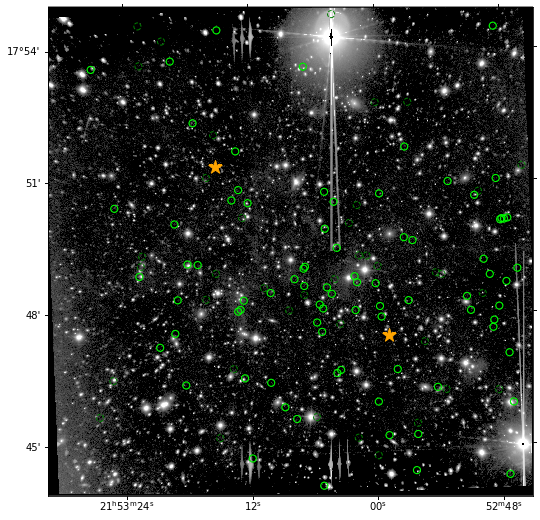

In [209]:
fig = plt.figure(figsize=(9,9))
ax = plt.subplot(111, projection=datacube.wcs)
plt.scatter(tab['X'], tab['Y'], s=50, facecolor="none", edgecolor="g", linestyle='--')

tab_iso = tab[tab['cen_offset_ISO-D']>0]
plt.scatter(tab_iso['X'], tab_iso['Y'], s=50, facecolor="none", edgecolor="lime")
plt.scatter(pos_BCG[:,0], pos_BCG[:,1], s=200, color="orange", marker="*")
plt.imshow(datacube.deep_frame, norm=norm1, cmap='gray', vmin=np.median(datacube.deep_frame), vmax=1e3)

(array([10., 29., 15., 10.,  2.,  5.,  1.,  1.,  0.,  1.,  0.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5]),
 <a list of 11 Patch objects>)

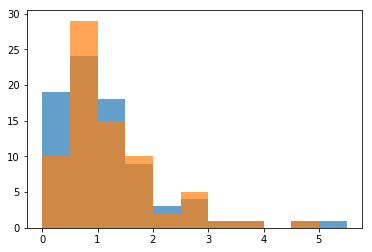

In [177]:
plt.hist(tab_A2465C['cen_offset_ISO-D'], bins=np.arange(0,6,0.5),alpha=0.7)
plt.hist(tab_A2465C['cen_offset_ISO-Dm'], bins=np.arange(0,6,0.5),alpha=0.7)

(array([11.,  7.,  5.,  9.,  6.,  3.]),
 array([  0.,  30.,  60.,  90., 120., 150., 180.]),
 <a list of 1 Patch objects>)

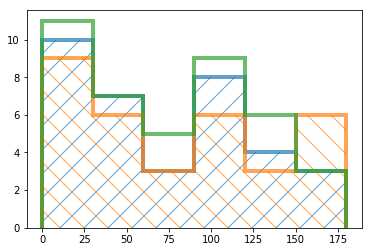

In [191]:
cond = condition_1
cond_iso = cond(tab_A2465C['cen_offset_ISO-D'], tab_A2465C['cen_offset_std_ISO-D'], tab_A2465C['z'], z0=0.245)
cond_mor = cond(tab_A2465C['cen_offset_ISO-Dm'], tab_A2465C['cen_offset_std_ISO-Dm'], tab_A2465C['z'], z0=0.245)
cond_aper = cond(tab_A2465C['cen_offset_APER'], tab_A2465C['cen_offset_std_APER'], tab_A2465C['z'], z0=0.245)
d_angle_iso = tab_A2465C['diff_angle_ISO-D'][cond_iso]
d_angle_mor = tab_A2465C['diff_angle_ISO-Dm'][cond_mor]
# d_angle_aper = tab_A2465C['diff_angle_APER'][cond_aper]
plt.hist(d_angle_iso, histtype="step", bins=np.linspace(0,180,7), hatch="/", lw=4, alpha=0.7)
plt.hist(d_angle_mor, histtype="step", bins=np.linspace(0,180,7), hatch="\\", lw=4, alpha=0.7)
# plt.hist(d_angle_aper, histtype="step", bins=np.linspace(0,180,7), hatch="||", lw=4, alpha=0.7)

cond_iso = cond(tab_A2465C['cen_offset_ISO-D'], tab_A2465C['cen_offset_std_ISO-D'], tab_A2465C['z'], z0=0.245, thre=0.806)
d_angle_iso = tab_A2465C['diff_angle_ISO-D'][cond_iso]
plt.hist(d_angle_iso, histtype="step", bins=np.linspace(0,180,7), lw=4, alpha=0.7)

(array([10.,  7.,  2.,  9.,  3.,  3.]),
 array([  0.,  30.,  60.,  90., 120., 150., 180.]),
 <a list of 1 Patch objects>)

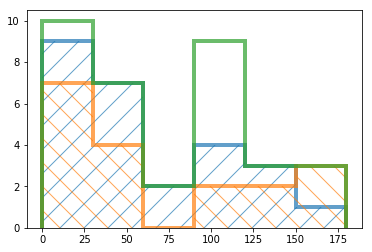

In [186]:
cond = condition_2
cond_iso = cond(tab_A2465C['cen_offset_ISO-D'], tab_A2465C['cen_offset_std_ISO-D'], tab_A2465C['z'], z0=0.245)
cond_mor = cond(tab_A2465C['cen_offset_ISO-Dm'], tab_A2465C['cen_offset_std_ISO-Dm'], tab_A2465C['z'], z0=0.245)
cond_aper = cond(tab_A2465C['cen_offset_APER'], tab_A2465C['cen_offset_std_APER'], tab_A2465C['z'], z0=0.245)
d_angle_iso = tab_A2465C['diff_angle_ISO-D'][cond_iso]
d_angle_mor = tab_A2465C['diff_angle_ISO-Dm'][cond_mor]
# d_angle_aper = tab_A2465C['diff_angle_APER'][cond_aper]
plt.hist(d_angle_iso, histtype="step", bins=np.linspace(0,180,7), hatch="/", lw=4, alpha=0.7)
plt.hist(d_angle_mor, histtype="step", bins=np.linspace(0,180,7), hatch="\\", lw=4, alpha=0.7)
# plt.hist(d_angle_aper, histtype="step", bins=np.linspace(0,180,7), hatch="||", lw=4, alpha=0.7)

cond_iso = cond(tab_A2465C['cen_offset_ISO-D'], tab_A2465C['cen_offset_std_ISO-D'], tab_A2465C['z'], z0=0.245, thre=0.806)
d_angle_iso = tab_A2465C['diff_angle_ISO-D'][cond_iso]
plt.hist(d_angle_iso, histtype="step", bins=np.linspace(0,180,7), lw=4, alpha=0.7)

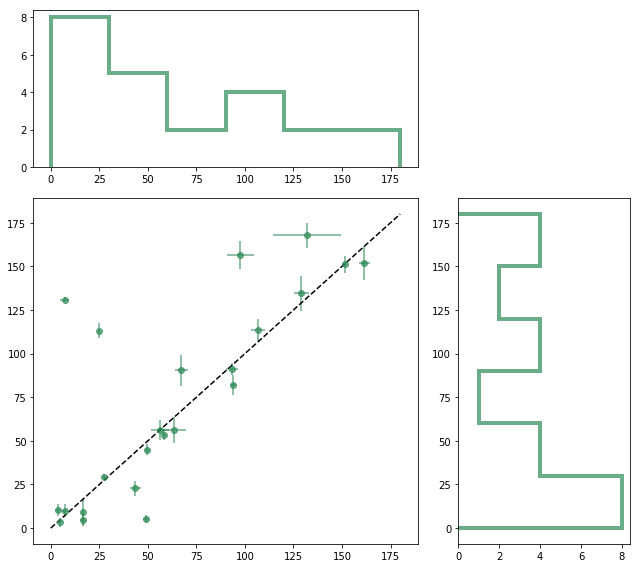

In [95]:
fig = plt.figure(figsize=(9,8))
ax1 = plt.subplot2grid((3, 3), (1, 0), rowspan=2, colspan=2)
ax1.errorbar(tab['diff_angle_ISO-D'][cond_iso&cond_mor], tab['diff_angle_ISO-Dm'][cond_iso&cond_mor],
             xerr=tab['diff_angle_std_ISO-D'][cond_iso&cond_mor],
             yerr=tab['diff_angle_std_ISO-Dm'][cond_iso&cond_mor], fmt="o", color="seagreen", alpha=0.7)
xx = np.linspace(0,180,10)
plt.plot(xx,xx,"k--")

ax2 = plt.subplot2grid((3, 3), (0, 0), colspan=2)
ax2.hist(tab['diff_angle_ISO-D'][cond_iso&cond_mor], histtype="step", bins=np.linspace(0,180,7),
         color="seagreen", lw=4, alpha=0.7)
ax3 = plt.subplot2grid((3, 3), (1, 2), rowspan=2)
ax3.hist(tab['diff_angle_ISO-Dm'][cond_iso&cond_mor], histtype="step", bins=np.linspace(0,180,7),
         color="seagreen", orientation="horizontal", lw=4, alpha=0.7, )
plt.tight_layout()